In the previous jupyter notebook, you engineered some features and split your data into training/validation/test sets. In this notebook, you will train your first predictive model using the K-Nearest Neighbors model and measure its performance. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

# Prepare data

We will load the training and validation sets. Note that we will not load the test set until we are completely done with tuning our models (in a few weeks).

In [3]:
df_train_all = pd.read_csv('df_train_all.csv')
df_valid= pd.read_csv('df_valid.csv')

In [4]:
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


At this point, you might say, drop the training data into a predictive model and see the outcome. However, if we do this, it is possible that we will get back a model that is 89% accurate. Great! Good job! But wait, we never catch any of the readmissions (recall= 0%). How can this happen? 

What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative. 

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:
    - sub-sample the more dominant class: use a random subset of the negatives
    - over-sample the imbalanced class: use the same positive samples multiple times
    - create synthetic positive data

Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement. 

In [5]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500


Now we have a balanced training set. 

Let's extract the column names for the inputs

In [6]:
col2use = [c for c in list(df_train_all.columns) if c != 'OUTPUT_LABEL']
print('Number of columns to use:', len(col2use))

Number of columns to use: 143


Some machine learning models can handle missing data, others cannot. In this project, we do not have any missing data, but I'll show you a technique that we can utilize if we did have missing data. 

The idea here is to fill missing data with the mean value. You want to use the mean value from the training data (since validation and test are completely unseen). I like to use the full training set. Since we will need to use the same preprocessing steps on the test data, we will store the mean values and make a function to do this. 

In [7]:
df_mean = df_train[col2use].mean(axis = 0)

In [8]:
df_mean.head()

time_in_hospital       4.518013
num_lab_procedures    43.280287
num_procedures         1.317709
num_medications       16.315426
number_outpatient      0.391792
dtype: float64

In [9]:
# save the means
df_mean.to_csv('df_mean.csv',index=True)

In [10]:
# load the means so we know how to do it for the test data
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])

In [11]:
df_mean_in.head()

,col,mean_val
0,time_in_hospital,4.518013
1,num_lab_procedures,43.280287
2,num_procedures,1.317709
3,num_medications,16.315426
4,number_outpatient,0.391792


Fill the rows with missing data with the mean value

In [13]:
def fill_my_missing(df, df_mean_in):
    # This function fills the missing values

    for c in col2use:
        mean_value = df_mean_in.loc[df_mean_in.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

In [14]:
df_train_all = fill_my_missing(df_train_all, df_mean_in)
df_train = fill_my_missing(df_train, df_mean_in)
df_valid = fill_my_missing(df_valid, df_mean_in)

Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [15]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


Some machine learning models have trouble when the variables are of different size (0-100, vs 0-1000000). To deal with that we can scale the data. Here we will use scikit learn's Standard Scaler  which removes the mean and scales to unit variance. Here I will create a scaler using all the training data, but you could use the balanced one if you wanted. 

In [16]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

C:\Program Files\Anaconda3\envs\pa_2018\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

You might get a warning about data conversion from int64 to float64. That is ok! 

Again, we will need this scaler for the test data, so let's save it using a package called `pickle`. 

In [17]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

Load it back:

In [18]:
scaler = pickle.load(open(scalerfile, 'rb'))

Now we can transform our data matrices 

In [19]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

C:\Program Files\Anaconda3\envs\pa_2018\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# First Model! 

Wow! so much work to get ready for a model. This is always true in data science. You spend 80-90% cleaning and preparing data. 

Let's train our first model with k-nearest neighbors with 3 lines of code. In this case, we will look at the closest 100 neighbors. 

In [20]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=100, p=2,
           weights='uniform')

We can now get class predictions (0,1) using `predict` or probabilities using `predict_proba` on new data. Here I am just using the first 5 rows since this could take a while to run. 

In [21]:
knn.predict(X_valid_tf[:5,:])

array([1, 0, 0, 0, 0], dtype=int64)

In [22]:
knn.predict_proba(X_valid_tf[:5,:])

array([[0.45, 0.55],
       [0.62, 0.38],
       [0.51, 0.49],
       [0.69, 0.31],
       [0.55, 0.45]])

Note that the second one returns two columns. To get the probability of class 1 (hospitalized within 30 days), we can use the second column

In [23]:
knn.predict_proba(X_valid_tf[:5,:])[:,1]

array([0.55, 0.38, 0.49, 0.31, 0.45])

let's get the prediction probabilities for the training and validation data. This may take a while. On my computer it took a few minutes. 

In [24]:
import time
t1 = time.time()
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]
t2 = time.time()
print(t2-t1)

138.12341165542603


We can evaluate the model. For homework, you will create your own functions to calculate these scores. 

In [25]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity 

In [26]:
thresh = 0.5
print('Training:')
print_report(y_train,y_train_preds, thresh)
print('Validation:')
print_report(y_valid,y_valid_preds, thresh);

Training:
AUC:0.650
accuracy:0.603
recall:0.491
precision:0.633
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.621
accuracy:0.670
recall:0.469
precision:0.165
specificity:0.655
prevalence:0.113
 


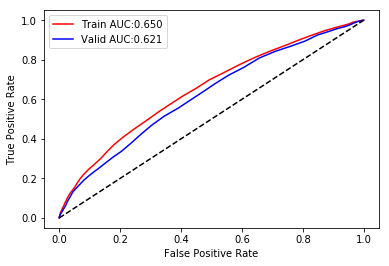

In [27]:
from sklearn.metrics import roc_curve 

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)


fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

plt.plot(fpr_train, tpr_train, 'r-',label ='Train AUC:%.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-',label ='Valid AUC:%.3f'%auc_valid)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

Our first model did pretty well. We have an AUC of 0.62 that catches 47% of the hospitalizations when we use a threshold of 0.5. Good job. Now it is your turn to do this on your own project! Next week we will talk about a few other predictive model algorithms! 

In [1]:
y_test_preds = knn.predict_proba(X_test_tf)[:,1]

NameError: name 'knn' is not defined